# DLSS-Project

In [75]:
#Necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from transformers import pipeline
import transformers
import re

In [46]:
#Import datasets from kaggle
comments = pd.read_csv("data/the-reddit-climate-change-dataset-comments.csv")
posts = pd.read_csv("data/the-reddit-climate-change-dataset-posts.csv")

## Preprocessing of Dataset for Descriptive Analysis

In [88]:
"""
Function converts the text to lower case letters.
    
Parameters
----------
argument: dataframe with text column
        
values: string
    
Returns
-------
the provided column with lower case letters
    
"""
def normalize_text(data, column_name):
    #Loop through tweets, check for datatyp and convert them to lower case
    for i, text in enumerate(data[column_name]):      
        if isinstance(text, str):
            data[column_name][i] = text.lower()
        else:
            return "Datatyp should be a string."

In [89]:
"""
Function removes in the "clean_tokens" column character which are not letters
    
Parameters
----------
argument: dataframe
dataframe with a "clean_tokens" column to convert
        
values: string
the values in the column are strings (with punctuation to remove)
    
Returns
-------
a adapted column "clean_tokens" with only letter characters.
    
"""
def remove_punctuation(data, column_name):
    # Create a new column with cleaned data
    cleaned_column = data[column_name].apply(lambda x: re.sub(r"[^\w\s]", "", x))
    
    # Return a new DataFrame with the cleaned column
    return data.assign(**{column_name: cleaned_column})

In [90]:
"""
Function removes in the "clean_tokens" column stopwords based on a imported text-file.
    
Parameters
----------
argument: dataframe
dataframe with a "clean_tokens" column to convert
        
values: string
the values in the column are strings
    
Returns
-------
a adapted column "clean_tokens" contains substrings which are not part of the 
eng_stop_words.txt file. 
    
"""
def remove_stop_words(text, stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [97]:
#Transformation of timestmamps to datetime
comments["created_utc"] = pd.to_datetime(comments["created_utc"], unit='s')

#Normalize text
normalize_text(comments,"body")

#Remove punctuation
remove_punctuation(comments,"body")

#Read english stopwords from file
with open("eng_stop_words.txt", "r") as file:
    stop_words = file.read().splitlines()
    
#Remove stopwords
comments["body"] = comments["body"].apply(lambda x: remove_stop_words(x, stop_words))

C:\Users\Jannik Wirtheim\AppData\Local\Temp\ipykernel_14148\1237409990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["created_utc"] = pd.to_datetime(test["created_utc"], unit='s')
C:\Users\Jannik Wirtheim\AppData\Local\Temp\ipykernel_14148\1552510868.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name][i] = text.lower()
C:\Users\Jannik Wirtheim\AppData\Local\Temp\ipykernel_14148\1552510868.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,imlddn9,2qh3l,news,False,2022-08-31 23:59:28,https://old.reddit.com/r/news/comments/x2cszk/...,yeah commenter saying base doesn’t want that. ...,0.5719,2
1,comment,imldbeh,2qn7b,ohio,False,2022-08-31 23:59:00,https://old.reddit.com/r/Ohio/comments/x2awnp/...,comparison efficiency solar fossil fuels nonse...,-0.9877,2
2,comment,imldado,2qhma,newzealand,False,2022-08-31 23:58:47,https://old.reddit.com/r/newzealand/comments/x...,i'm honestly waiting climate change impacts ki...,-0.1143,1
3,comment,imld6cb,2qi09,sacramento,False,2022-08-31 23:57:58,https://old.reddit.com/r/Sacramento/comments/x...,sacramento. it's actually happening world. cli...,0.0000,4
4,comment,imld0kj,2qh1i,askreddit,False,2022-08-31 23:56:46,https://old.reddit.com/r/AskReddit/comments/x2...,think climate change tends get people riled up...,0.6634,1


In [98]:
from langdetect import detect

#Detect the language of a text
def detect_language(text):
    try:
        return detect(text)
    except:
        return None
    
#Apply the function to the posts
comments["language"] = comments["body"].apply(detect_language)

#Keep only posts detected as English ('en')
df_english = comments[comments["language"] == "en"]

#Drop the language column
comments = df_english.drop(columns=["language"])

#Save dataframe as .csv
comments.to_csv("filtered_comments.csv", index=False)

C:\Users\Jannik Wirtheim\AppData\Local\Temp\ipykernel_14148\3397407949.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["language"] = test["body"].apply(detect_language)


## Sentiment Analysis

#### Given Sentiment in dataset


In [116]:
"""
The function takes the sentiment scores in the "VADER_compound" column
and allocate a positive (> 0.5), negative (< -0.5) or else neutral label 
to the data in a new column "VADER_class".
    
Parameters
----------
argument: 
A dataframe with a "VADER_compound"-column to analyse
        
values: strings
    
Returns
-------
The dataframe with a new column "VADER_class" 
with a the string-based sentiment score.
    
"""

def label_scores(data):
    VADER_sentiment_label = []
    #Loop through sentiment scores and check if text is positive, negative or neutral and append results to VADER_sentiment_label
    for score in data["sentiment"]:
        if score < -0.5:
            VADER_sentiment_label.append("Negative")
        elif score > 0.5:
            VADER_sentiment_label.append("Positive")
        else:
            VADER_sentiment_label.append("Neutral")

    #Create a new column with label
    data["sentiment_class"] = VADER_sentiment_label
    
#Apply label_scores() on tweets
label_scores(comments)

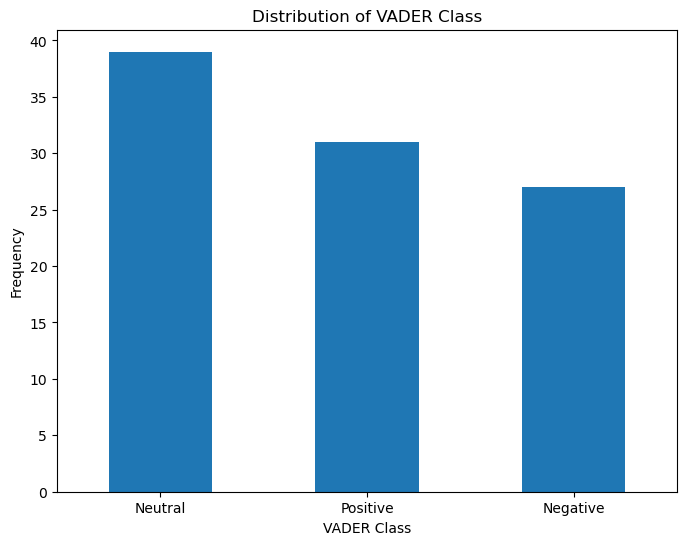

In [117]:
#Plotting the distribution of VADER_class
plt.figure(figsize=(8, 6))
comments['sentiment_class'].value_counts().plot(kind='bar')
plt.title('Distribution of VADER Class')
plt.xlabel('VADER Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

#### Apply VADER on Comment Data

We tried to use RoBERTa which offers a better classfication accuracy than VADER. But we had problems with the length of the sentences which were not unfeasable for RoBETa.

In [103]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

"""
The function calculates a VADER sentiment analysis 
and append the sentiment scores to a new column "VADER_compound"
    
Parameters
----------
argument: 
A dataframe with a "text"-column to analyse
        
values: strings
    
Returns
-------
The dataframe with a new column "VADER_compound" 
with the sentiment scores of each text as float.
    
"""

def sentiment_scores(data):
    sia = SentimentIntensityAnalyzer()
    #Loop through rows, calculate sentiment score and append it to a sentimet_scores list
    sentimet_scores = []
    for i, row in enumerate(data["body"]):
        scores = sia.polarity_scores(row)
        sentimet_scores.append(scores)
    
    #Create new column "VADER_compound" with compound scores
    data["VADER_compound"] = data["body"].apply(lambda text: sia.polarity_scores(text)["compound"])
    
    #Convert to float values
    data["VADER_compound"] = data["VADER_compound"].astype(float)

sentiment_scores(comments)

In [108]:
"""
The function takes the sentiment scores in the "VADER_compound" column
and allocate a positive (> 0.5), negative (< -0.5) or else neutral label 
to the data in a new column "VADER_class".
    
Parameters
----------
argument: 
A dataframe with a "VADER_compound"-column to analyse
        
values: strings
    
Returns
-------
The dataframe with a new column "VADER_class" 
with a the string-based sentiment score.
    
"""

def label_scores(data):
    VADER_sentiment_label = []
    #Loop through sentiment scores and check if text is positive, negative or neutral and append results to VADER_sentiment_label
    for score in data["VADER_compound"]:
        if score < -0.5:
            VADER_sentiment_label.append("Negative")
        elif score > 0.5:
            VADER_sentiment_label.append("Positive")
        else:
            VADER_sentiment_label.append("Neutral")

    #Create a new column with label
    data["VADER_class"] = VADER_sentiment_label
    
#Apply label_scores() on tweets
label_scores(comments)
comments = comments.drop(columns=["VADER_compound"])

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score,VADER_class
0,comment,imlddn9,2qh3l,news,False,2022-08-31 23:59:28,https://old.reddit.com/r/news/comments/x2cszk/...,yeah commenter saying base doesn’t want that. ...,0.5719,2,Positive
1,comment,imldbeh,2qn7b,ohio,False,2022-08-31 23:59:00,https://old.reddit.com/r/Ohio/comments/x2awnp/...,comparison efficiency solar fossil fuels nonse...,-0.9877,2,Negative
2,comment,imldado,2qhma,newzealand,False,2022-08-31 23:58:47,https://old.reddit.com/r/newzealand/comments/x...,i'm honestly waiting climate change impacts ki...,-0.1143,1,Neutral
3,comment,imld6cb,2qi09,sacramento,False,2022-08-31 23:57:58,https://old.reddit.com/r/Sacramento/comments/x...,sacramento. it's actually happening world. cli...,0.0000,4,Neutral
4,comment,imld0kj,2qh1i,askreddit,False,2022-08-31 23:56:46,https://old.reddit.com/r/AskReddit/comments/x2...,think climate change tends get people riled up...,0.6634,1,Positive


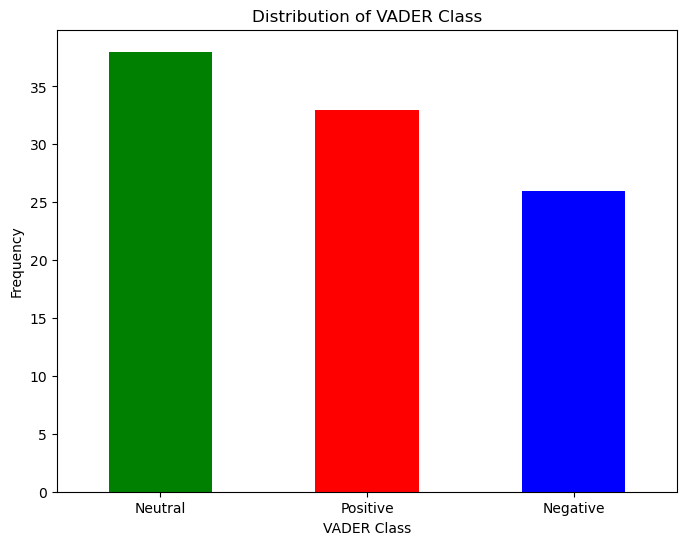

In [109]:
#Plotting the distribution of VADER_class
plt.figure(figsize=(8, 6))
comments['VADER_class'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of VADER Class')
plt.xlabel('VADER Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

#### Apply LEIA on Comment Data

In [110]:
#Loading LEIA as a pipline
pipe = pipeline("text-classification", model="LEIA/LEIA-base", truncation=True, max_length=128)

In [111]:
#Apply Leia to each sentence and store the results in new column Leia_Label
comments["Leia_Label"] = [pipe(text)[0]["label"] for text in comments["body"]]

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score,VADER_class,Leia_Label
0,comment,imlddn9,2qh3l,news,False,2022-08-31 23:59:28,https://old.reddit.com/r/news/comments/x2cszk/...,yeah commenter saying base doesn’t want that. ...,0.5719,2,Positive,Anger
1,comment,imldbeh,2qn7b,ohio,False,2022-08-31 23:59:00,https://old.reddit.com/r/Ohio/comments/x2awnp/...,comparison efficiency solar fossil fuels nonse...,-0.9877,2,Negative,Anger
2,comment,imldado,2qhma,newzealand,False,2022-08-31 23:58:47,https://old.reddit.com/r/newzealand/comments/x...,i'm honestly waiting climate change impacts ki...,-0.1143,1,Neutral,Anger
3,comment,imld6cb,2qi09,sacramento,False,2022-08-31 23:57:58,https://old.reddit.com/r/Sacramento/comments/x...,sacramento. it's actually happening world. cli...,0.0000,4,Neutral,Fear
4,comment,imld0kj,2qh1i,askreddit,False,2022-08-31 23:56:46,https://old.reddit.com/r/AskReddit/comments/x2...,think climate change tends get people riled up...,0.6634,1,Positive,Happiness
...,...,...,...,...,...,...,...,...,...,...,...,...
95,comment,iml763f,2qh24,philadelphia,False,2022-08-31 23:13:46,https://old.reddit.com/r/philadelphia/comments...,probably much. sindh province received 784% hi...,0.1777,47,Neutral,Fear
96,comment,iml75ta,2qh3z,college,False,2022-08-31 23:13:42,https://old.reddit.com/r/college/comments/x2fr...,commuted bike several years grad school louisi...,0.9778,11,Positive,Anger
97,comment,iml73o3,2qwzm,electricvehicles,False,2022-08-31 23:13:15,https://old.reddit.com/r/electricvehicles/comm...,understanding california special exemption cre...,0.8176,7,Positive,Anger
98,comment,iml72qz,2qhw9,collapse,False,2022-08-31 23:13:03,https://old.reddit.com/r/collapse/comments/x2i...,sounds like 20 years even begin fix climate ch...,0.5423,2,Positive,Anger


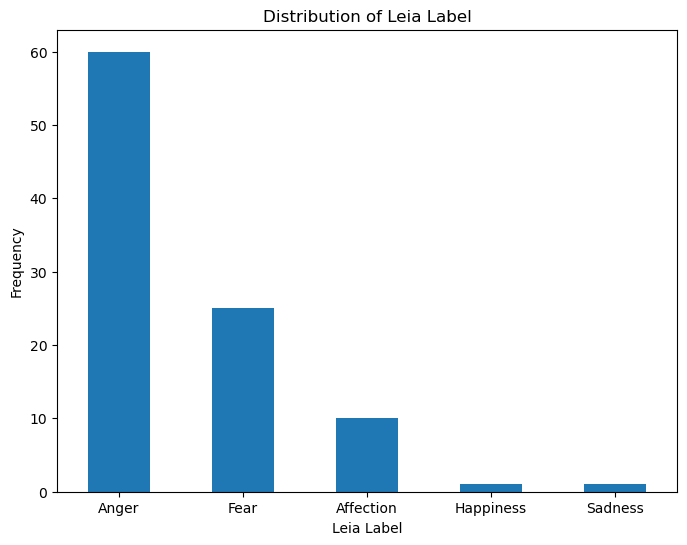

In [113]:
# Plotting the distribution of Leia_Label
plt.figure(figsize=(8, 6))
comments['Leia_Label'].value_counts().plot(kind='bar')
plt.title('Distribution of Leia Label')
plt.xlabel('Leia Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

# Plots for Descriptive Analysis

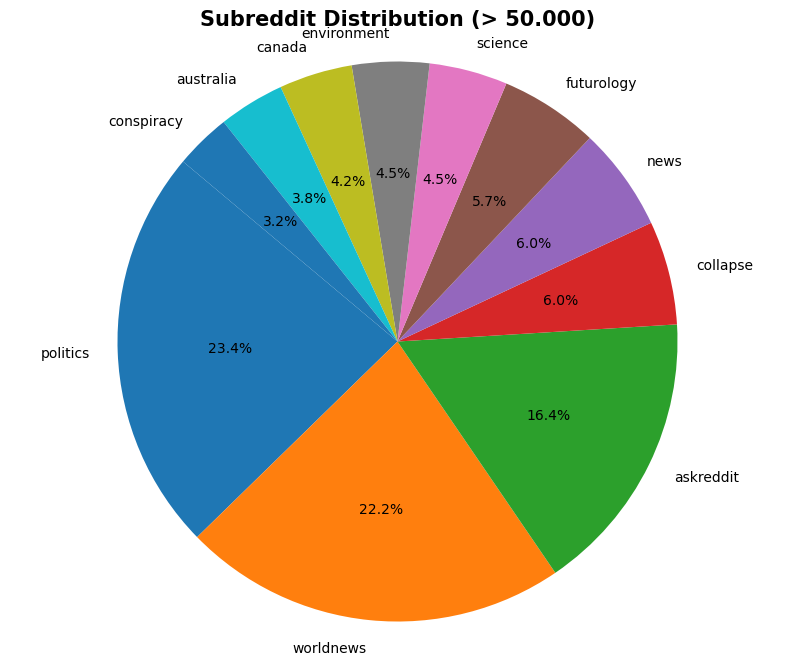

In [8]:
# Calculate the value counts
value_counts = comments["subreddit.name"].value_counts()

# Calculate others
others_count = value_counts[value_counts < 50000].sum()

# Create a new DataFrame for plotting
plot_data = value_counts[value_counts >= 50000]
plot_data['others'] = others_count

# Remove 'others' from the plot_data
plot_data = plot_data[plot_data.index != 'others']

# Create a pie chart without 'others'
plt.figure(figsize=(10, 8))
plt.pie(plot_data, labels=plot_data.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.title('Subreddit Distribution (> 50.000)', fontweight='bold', fontsize = 15)
plt.show()